# 在测试试管中模拟生长
此简单示例展示了COMETS的基本工作流程，包括如何构建模拟布局、指定参数、加载模型以及在模拟完成后绘制数据。

COMETS方法的核心是动态flux平衡分析算法（Dynamic Flux Balance Analysis，由Madahevan等人于2002年提出）。对细菌代谢动力学时序进行首批成功模拟的研究之一就是Varma和Palsson（1994年）关于大肠杆菌批次培养的经典研究。此处，我们将重现该研究中的一个结果，即在仅含葡萄糖作为唯一碳源的最小培养基中进行厌氧发酵的过程。

我们将通过设定一个充分混合的虚拟容器来模拟试管实验，其中装有1立方厘米的培养基，并接种5×10^-6克的大肠杆菌生物质。我们将底物初始组成设为11毫摩尔的葡萄糖，并提供不限量的氨和磷酸盐。对于营养物质的吸收，我们将采用经典的Michaelis-Menten动力学，使用实验测定的大肠杆菌厌氧吸收葡萄糖的Monod参数。

在这个简单的示例中，我们使用了大肠杆菌的基础“核心”模型（Orth等人，2009年），该模型可以从http://bigg.ucsd.edu/models/e_coli_core网站下载，或者像这里所做的那样，利用CobraPy内置函数直接加载。这个模型代表了简化到基本功能（如糖酵解、三羧酸循环、戊糖磷酸途径等）的大肠杆菌代谢网络。

# 导入COMETS Python 工具箱
该操作同时会载入所有必需的依赖库，比如 CobraPy 或 pandas。

In [1]:
import cometspy as c
import cobra.io
import matplotlib.pyplot as plt

# 为模拟创建一个“布局”
通过无参数实例化layout类，我们将创建默认的模拟布局，它表示一个体积为1立方厘米且充分混合的空间（称为“细胞”）。然后我们可以根据需要修改这个布局，在本例中，我们会添加期望浓度下的培养基成分。

In [2]:
# Create empty 1x1 layout
test_tube = c.layout()

# Add 11mM glucose and remove o2
test_tube.set_specific_metabolite('glc__D_e', 0.011)
test_tube.set_specific_metabolite('o2_e', 0)

# Add the rest of nutrients unlimited (ammonia, phosphate, water and protons)
test_tube.set_specific_metabolite('nh4_e',1000);
test_tube.set_specific_metabolite('pi_e',1000);
test_tube.set_specific_metabolite('h2o_e',1000);
test_tube.set_specific_metabolite('h_e',1000);

building empty layout model
models will need to be added with layout.add_model()


C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\layout.py:826: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.media = pd.concat([self.media,


# 装载模型
下一步，我们需要加载模型并将它添加到布局中（或者说，“将模型接种到我们的试管环境中”）。

我们将通过已加载的CobraPy模型作为输入来实例化COMETS模型类。

需要注意的是，我们将去除对葡萄糖进口速率的限制，这一限制将在模拟过程中由COMETS根据外部葡萄糖浓度的动态变化来动态设置。同时，我们将模型的初始生物质量设置为10^-6克。

In [3]:
# create the model using CobraPy functionality
e_coli_cobra = cobra.io.load_model('textbook')

# use the loaded model to build a comets model
e_coli = c.model(e_coli_cobra)

# remove the bounds from glucose import (will be set dynamically by COMETS)
e_coli.change_bounds('EX_glc__D_e', -1000, 1000)

# set the model's initial biomass
e_coli.initial_pop = [0, 0, 5e-6]

# add it to the test_tube
test_tube.add_model(e_coli)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:623: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.smat = pd.concat([self.smat, cdf])
C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:636: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


# 设置模拟参数
接下来，我们实例化params类，该类为COMETS模拟生成一套参数集，其中包含了所有参数的[待补充链接至默认值]默认值。所有参数都保存在all_params字段中，这是一个Python字典对象，因此可以方便地更改所需参数的值。

In [4]:
# Set the parameters that are different from the default
sim_params = c.params()
sim_params.set_param('defaultVmax', 18.5)
sim_params.set_param('defaultKm', 0.000015)
sim_params.set_param('maxCycles', 1000)
sim_params.set_param('timeStep', 0.01)
sim_params.set_param('spaceWidth', 1)
sim_params.set_param('maxSpaceBiomass', 10)
sim_params.set_param('minSpaceBiomass', 1e-11)
sim_params.set_param('writeMediaLog', True)

# 运行模拟
配置完毕后，我们现在可以通过传递包含模型的layout（布局）以及我们刚才创建的params对象来实例化comets类，从而运行模拟。

In [5]:
experiment = c.comets(test_tube, sim_params)

最后，我们可以这样运行模拟：

In [6]:
experiment.run()


Running COMETS simulation ...
Done!


# 结果分析

我们模拟得到的结果储存在刚刚模拟完成的comets对象内部的几个pandas数据框中。通过绘制total_biomass字段，可以看到模拟模型的生长情况。

Text(0, 0.5, 'Biomass (gr.)')

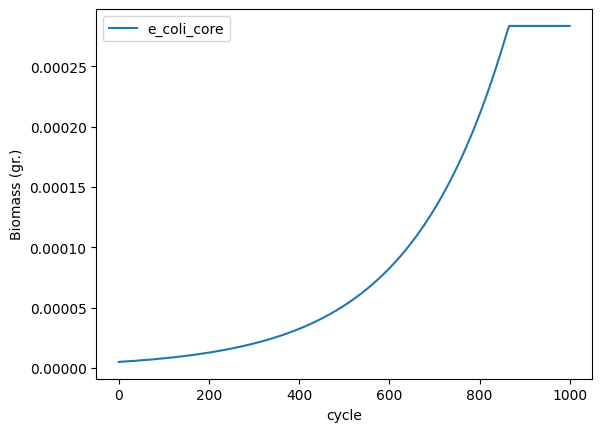

In [7]:
ax = experiment.total_biomass.plot(x = 'cycle')
ax.set_ylabel("Biomass (gr.)")

同样地，我们可以绘制培养基的组成情况。在这个案例中，我们将限制绘图范围仅针对那些在模拟过程中不是以不限量方式添加到体系中的组分（即“静态”化合物，比如在此模拟中氨、磷酸盐、水等）。具体实现时，我们通过限定浓度小于900毫摩尔的化合物来进行这一部分的绘图展示。

Text(0, 0.5, 'Concentration (mmol)')

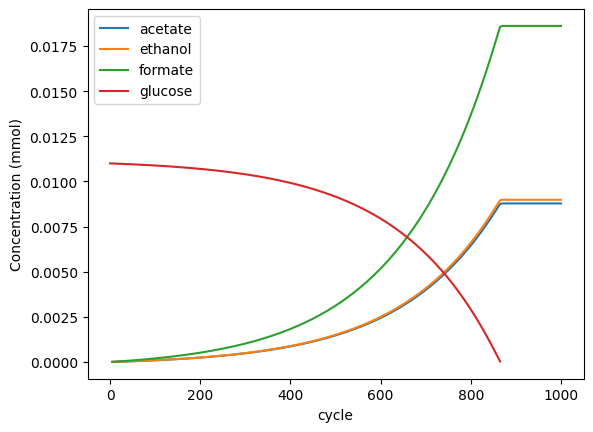

In [8]:
media = experiment.media.copy()
media = media[media.conc_mmol<900]

fig, ax = plt.subplots()
media.groupby('metabolite').plot(x='cycle', ax =ax, y='conc_mmol')
ax.legend(('acetate','ethanol', 'formate', 'glucose'))
ax.set_ylabel("Concentration (mmol)")